In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv


In [2]:
!wc -l /kaggle/input/ashrae-energy-prediction/train.csv

20216101 /kaggle/input/ashrae-energy-prediction/train.csv


In [3]:
from pathlib import PosixPath

In [4]:
base_path = PosixPath('/kaggle/input/ashrae-energy-prediction')

# load data
base_df = pd.read_csv(base_path/'train.csv')
metadata_df = pd.read_csv(base_path/'building_metadata.csv')
weather_df = pd.read_csv(base_path/'weather_train.csv')

In [5]:
base_df['meter'].value_counts()

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

In [6]:
base_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [7]:
metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [8]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [9]:
base_df.isna().sum() / len(base_df)

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [10]:
meter_id_to_cat = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

In [11]:
weather_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

# Reconcile weather data

In [12]:
siteZero = weather_df[weather_df['site_id'] == 0]
siteZero.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [13]:
siteZero['hour'] = pd.DatetimeIndex(siteZero.set_index('timestamp').index).hour

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
tempPerHour = siteZero.groupby('hour')['air_temperature']

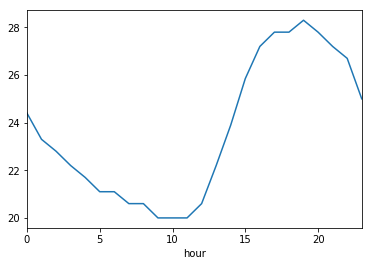

In [15]:
tempPerHour.median().plot()

In [16]:
import matplotlib.pyplot as plt

## Raw temperature readings

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


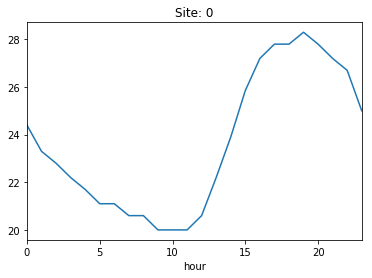

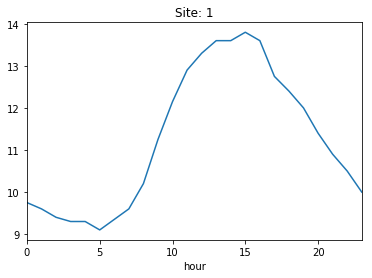

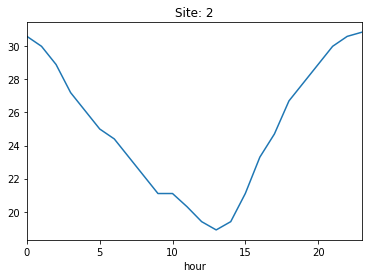

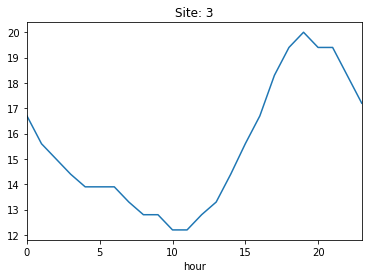

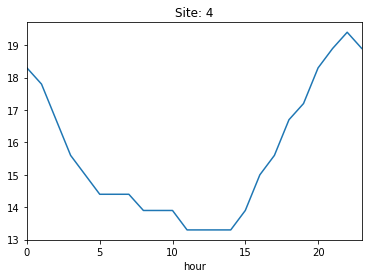

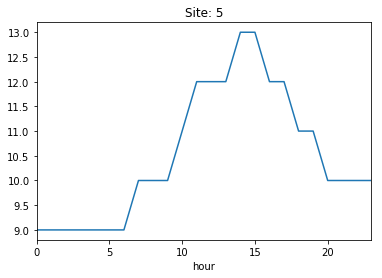

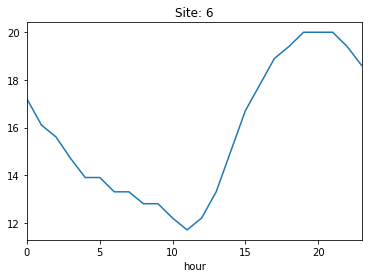

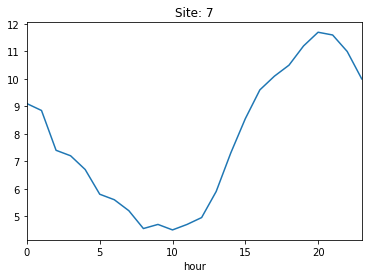

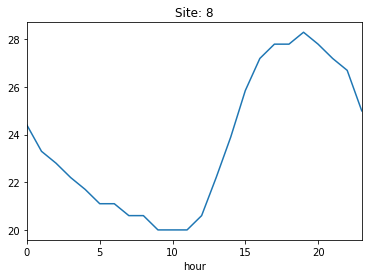

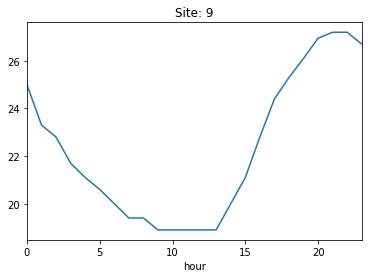

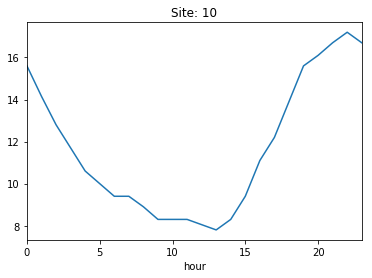

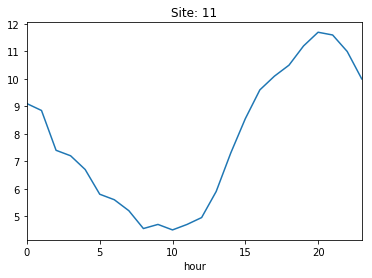

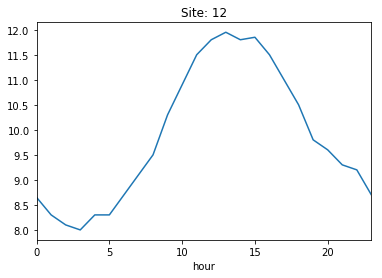

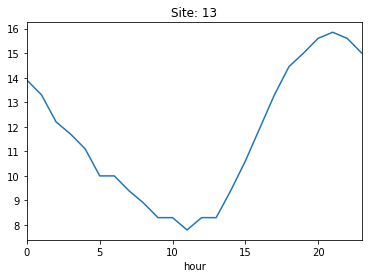

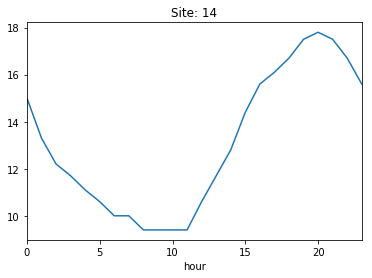

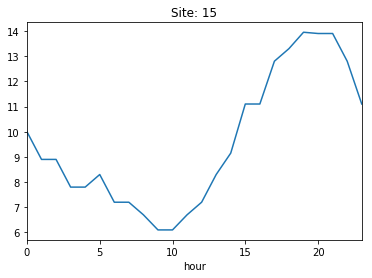

In [17]:
for site in weather_df['site_id'].unique():
    current_site = weather_df[weather_df['site_id'] == site]
    current_site['hour'] = pd.DatetimeIndex(current_site.set_index('timestamp').index).hour
    tempPerHour = current_site.groupby('hour')['air_temperature']
    tempPerHour.median().plot(title=site)
    plt.title(f'Site: {site}')
    plt.show()

## Align temperature data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

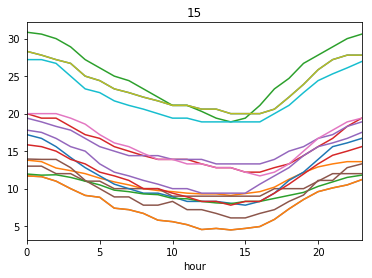

In [18]:
time_offsets = {}

for site in weather_df['site_id'].unique():
    siteZero = weather_df[weather_df['site_id'] == site]
    siteZero['hour'] = pd.DatetimeIndex(siteZero.set_index('timestamp').index).hour
    tempPerHour = siteZero.groupby('hour')['air_temperature']
    trend = siteZero.groupby('hour')['air_temperature'].median()
    time_offsets[site] = trend.idxmax()
    trend.index = (trend.index - trend.idxmax()) % 24
    trend.sort_index().plot(title=site)

# Join data frames

In [19]:
modeling_df = base_df.set_index('building_id')

In [20]:
base_and_meta = modeling_df.join(metadata_df, on='building_id')
base_and_meta = base_and_meta.drop('building_id', axis=1).reset_index()

In [21]:
training_df = pd.merge(base_and_meta, weather_df)

In [22]:
training_df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20125600,1444,0,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20125601,1445,0,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20125602,1446,0,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20125603,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [24]:
training_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [25]:
dtypes = {'timestamp': 'datetime',
          'primary_use': 'category',
         }
training_df['timestamp'] = pd.to_datetime(training_df['timestamp'])
training_df['primary_use'] = training_df['primary_use'].astype('category')

In [26]:
training_df.dtypes

building_id                    int64
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
site_id                        int64
primary_use                 category
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

In [27]:
cat_columns = ['site_id', 'primary_use']
cont_columns = ['square_feet', 'year_built', 'floor_count',
               'air_temperature', 'cloud_coverage', 'dew_temperature',
               'precip_depth_1_hr', 'sea_level_pressure',
               'wind_direction', 'wind_speed']

In [28]:
encoders = {}
for col in cat_columns:
    encoders[col] = LabelEncoder()
    encoders[col].fit_transform(training_df[col])

## Impute medians

In [29]:
# Alternative imputing approaches
# Interpolate
# group by site id to generate medians

In [38]:
training_df.values

(20125605, 16)

In [43]:
median_dict = weather_df.median().to_dict()

In [44]:
median_dict.update(metadata_df.median().to_dict())

In [48]:
for col, med in median_dict.items():
    training_df[col].fillna(med, inplace=True)

## Split on meter type

In [54]:
training_df['meter'].value_counts()

0    12017408
1     4160093
2     2686678
3     1261426
Name: meter, dtype: int64

In [57]:
# Take the smallest one for fun
elec_train_df = training_df[training_df['meter'] == 3]

In [70]:
import xgboost as xgb

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [68]:
model = xgb.XGBRegressor()

In [71]:
target = 'meter_reading'
X_train = elec_train_df.drop(target, axis=1)
y_train = elec_train_df[target]

> ## Parameter Search

In [66]:
from sklearn.model_selection import RandomizedSearchCV

In [65]:
RandomizedSearchCV(xgb.XGBRegressor, param_distributions={})

TypeError: __init__() missing 1 required positional argument: 'param_distributions'